In [1]:
from __future__ import division, print_function, absolute_import

# Import cervical cancer MRI image data
import numpy as np
import tensorflow as tf

train_data = np.load('train_data224.npy')
np.random.shuffle(train_data)
# Training Parameters
learning_rate = 0.001
num_steps = 4000
batch_size = 96

# Network Parameters
num_input = 50176 # data input (img shape: 224*224)
num_classes = 3 # total classes (0-2  digits)
dropout = 0.99 # Dropout, probability to keep units

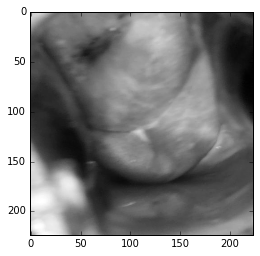

In [2]:
# example image
import matplotlib.pyplot as plt
plt.imshow(train_data[0][0],cmap='gray')
plt.show()

In [3]:
# Train dataset
train_X = np.zeros((1280,50176),dtype=np.float32)
for i in range(1280):
    train_X[i] = train_data[0:1280,0][i].ravel()

train_Y=np.array(train_data[0:1280,1],dtype=np.int32)

# Test dataset
test_X = np.zeros((200,50176),dtype=np.float32)
for i in range(200):
    test_X[i] = train_data[1280:1480,0][i].ravel()

test_Y=np.array(train_data[1280:1480,1],dtype=np.int32)

# Normalize 
train_X -= np.mean(train_X, axis = 0)
train_X /= np.std(train_X, axis = 0) 
test_X -= np.mean(test_X, axis = 0)
test_X /= np.std(test_X, axis = 0) 

In [4]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']
        #x = x_dict

        # input is a 1-D vector of 50176 features (224*224 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 224, 224, 1])

        # Convolution Layer with 64 filters and a kernel size of 3
        conv1 = tf.layers.conv2d(x, 64, 3, activation=tf.nn.relu)
        conv1 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 128 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 128, 3, activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv2, 128, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
   
        # Convolution Layer with 256 filters and a kernel size of 3
        conv3 = tf.layers.conv2d(conv2, 256, 3, activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv3, 256, 3, activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv3, 256, 3, activation=tf.nn.relu)
        conv3 = tf.layers.max_pooling2d(conv3, 2, 2)
        
        # Convolution Layer with 256 filters and a kernel size of 3
        conv4 = tf.layers.conv2d(conv3, 256, 3, activation=tf.nn.relu)
        conv4 = tf.layers.conv2d(conv4, 256, 3, activation=tf.nn.relu)
        conv4 = tf.layers.conv2d(conv4, 256, 3, activation=tf.nn.relu)
        conv4 = tf.layers.max_pooling2d(conv4, 2, 2)
        
        # Convolution Layer with 512 filters and a kernel size of 3
        conv5 = tf.layers.conv2d(conv4, 512, 3, activation=tf.nn.relu)
        conv5 = tf.layers.conv2d(conv5, 512, 3, activation=tf.nn.relu)
        conv5 = tf.layers.conv2d(conv5, 512, 3, activation=tf.nn.relu)
        conv5 = tf.layers.max_pooling2d(conv5, 2, 2)
        
        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv5)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 4096)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        
        fc2 = tf.layers.dense(fc1, 2048)
        fc2 = tf.layers.dropout(fc2, rate=dropout, training=is_training)
        
        fc3 = tf.layers.dense(fc2, 1026)
        fc3 = tf.layers.dropout(fc3, rate=dropout, training=is_training)
        
        fc4 = tf.layers.dense(fc3, 512)
        fc4 = tf.layers.dropout(fc4, rate=dropout, training=is_training)        
        
        fc5 = tf.layers.dense(fc4, 128)
        fc5 = tf.layers.dropout(fc5, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc5, n_classes)

    return fc1


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [5]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': train_X}, y=train_Y,batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)
# Evaluate Training Accuracy
#et = model.evaluate(input_fn)
#print("Training Accuracy:", et['accuracy'])

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': test_X}, y=test_Y,batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)
print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpc1zptta2/model.ckpt.
INFO:tensorflow:step = 1, loss = 8.3178
INFO:tensorflow:global_step/sec: 0.278115
INFO:tensorflow:step = 101, loss = 8.23672 (359.565 sec)
INFO:tensorflow:Saving checkpoints for 168 into /tmp/tmpc1zptta2/model.ckpt.
INFO:tensorflow:global_step/sec: 0.279406
INFO:tensorflow:step = 201, loss = 8.24066 (357.902 sec)
INFO:tensorflow:global_step/sec: 0.282136
INFO:tensorflow:step = 301, loss = 8.07151 (354.439 sec)
INFO:tensorflow:Saving checkpoints for 338 into /tmp/tmpc1zptta2/model.ckpt.
INFO:tensorflow:global_step/sec: 0.281821
INFO:tensorflow:step = 401, loss = 8.31351 (354.835 sec)
INFO:tensorflow:global_step/sec: 0.282247
INFO:tensorflow:step = 501, loss = 8.26144 (354.300 sec)
INFO:tensorflow:Saving checkpoints for 508 into /tmp/tmpc1zptta2/model.ckpt.
INFO:tensorflow:global_step/sec: 0.281807
IN